In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {}\n    Negative: {}'.format(total, pos, neg))

Examples:
    Total: 284807
    Positive: 492
    Negative: 284315


In [6]:
cleaned_df = raw_df.copy()

cleaned_df.pop('Time')

eps = 0.001
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount') + eps)

In [7]:
cleaned_df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,0.001727,2.942089
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527,2.023685
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,-6.907755
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000,1.722945
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,3.091088
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000,4.345959
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,10.153902


In [8]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Train features shape: ', train_features.shape)
print('Validation features shape: ', val_features.shape)
print('Test features shape: ', test_features.shape)

print('Train labels shape: ', train_labels.shape)
print('Validation labels shape: ', val_labels.shape)
print('Test labels shape: ', test_labels.shape)

Train features shape:  (182276, 29)
Validation features shape:  (45569, 29)
Test features shape:  (56962, 29)
Train labels shape:  (182276,)
Validation labels shape:  (45569,)
Test labels shape:  (56962,)


In [10]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Positive distribution')

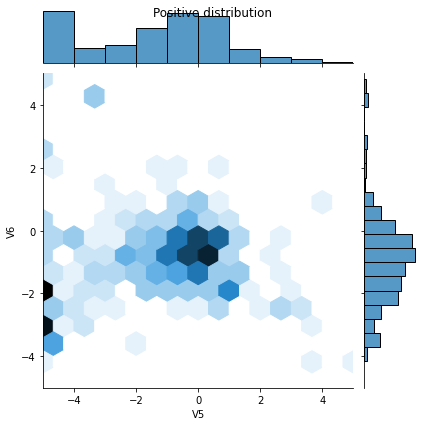

In [11]:
sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle('Positive distribution')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


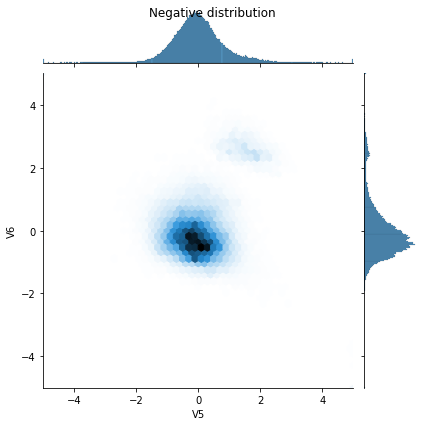

In [12]:
sns.jointplot(neg_df['V5'], neg_df['V6'], kind='hex', xlim=(-5, 5), ylim=(-5, 5))
_ = plt.suptitle('Negative distribution')

In [13]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1], )),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy(), metrics=metrics)

    return model

In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=10, mode='max', restore_best_weights=True)

In [15]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.predict(train_features[:10])

array([[0.19453809],
       [0.16971096],
       [0.27820793],
       [0.27605933],
       [0.21329275],
       [0.26192117],
       [0.28258228],
       [0.12774971],
       [0.19895095],
       [0.17694321]], dtype=float32)

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE)

90/90 [==============================] - 2s 8ms/step - loss: 0.3072 - tp: 8.0000 - fp: 6814.0000 - tn: 175153.0000 - fn: 301.0000 - accuracy: 0.9610 - precision: 0.0012 - recall: 0.0259 - auc: 0.3581 - prc: 0.0015


In [18]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [19]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00432885],
       [0.00151712],
       [0.00276861],
       [0.00132555],
       [0.00314865],
       [0.00322288],
       [0.00424349],
       [0.0009293 ],
       [0.00122479],
       [0.00235784]], dtype=float32)

In [20]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {}'.format(results[0]))

Loss: 0.009716167114675045


In [21]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [22]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(train_features, train_labels, epochs=20, batch_size=BATCH_SIZE, validation_data=(val_features, val_labels), verbose=0)

In [23]:
model = make_model()
model.load_weights(initial_weights)

careful_bias_history = model.fit(train_features, train_labels, epochs=20, batch_size=BATCH_SIZE, validation_data=(val_features, val_labels), verbose=0)

In [24]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

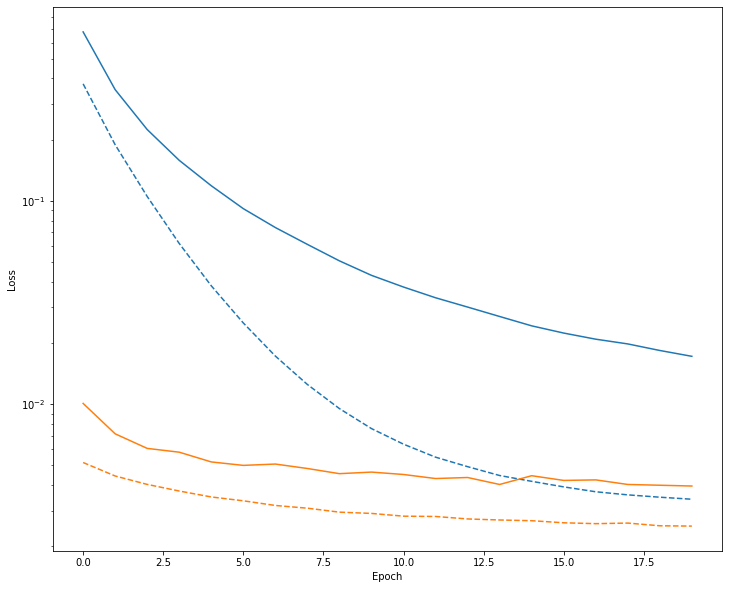

In [25]:
plot_loss(zero_bias_history, 'Zero bias', 0)
plot_loss(careful_bias_history, 'Careful bias', 1)

In [26]:
model = make_model()
model.load_weights(initial_weights)

baseline_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_features, val_labels), callbacks=[early_stopping])

Epoch 1/100
90/90 [==============================] - 4s 23ms/step - loss: 0.0106 - tp: 155.0000 - fp: 104.0000 - tn: 227352.0000 - fn: 234.0000 - accuracy: 0.9985 - precision: 0.5985 - recall: 0.3985 - auc: 0.8451 - prc: 0.3806 - val_loss: 0.0054 - val_tp: 33.0000 - val_fp: 5.0000 - val_tn: 45484.0000 - val_fn: 47.0000 - val_accuracy: 0.9989 - val_precision: 0.8684 - val_recall: 0.4125 - val_auc: 0.9488 - val_prc: 0.7566
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0074 - tp: 133.0000 - fp: 31.0000 - tn: 181936.0000 - fn: 176.0000 - accuracy: 0.9989 - precision: 0.8110 - recall: 0.4304 - auc: 0.8603 - prc: 0.4835 - val_loss: 0.0045 - val_tp: 40.0000 - val_fp: 7.0000 - val_tn: 45482.0000 - val_fn: 40.0000 - val_accuracy: 0.9990 - val_precision: 0.8511 - val_recall: 0.5000 - val_auc: 0.9495 - val_prc: 0.7739
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0063 - tp: 147.0000 - fp: 35.0000 - tn: 181932.0000 - fn: 162.0000 - accura

In [27]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()

        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)

        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        
        plt.legend()

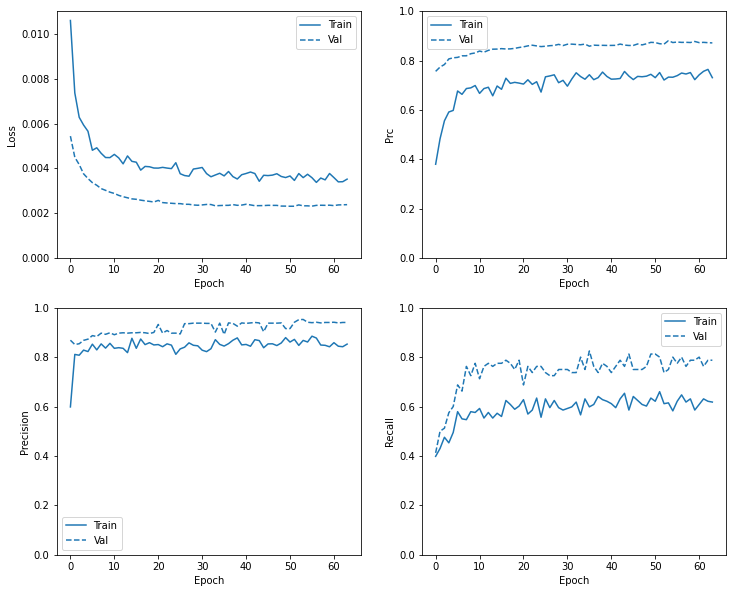

In [28]:
plot_metrics(baseline_history)

In [29]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [30]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negative): ', cm[0][0])
    print('Legitimate Transactions Incorrectly detected (False Positive): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negative): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positive): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0027285984251648188
tp :  80.0
fp :  5.0
tn :  56854.0
fn :  23.0
accuracy :  0.9995084404945374
precision :  0.9411764740943909
recall :  0.7766990065574646
auc :  0.936650276184082
prc :  0.8570238351821899

Legitimate Transactions Detected (True Negative):  56854
Legitimate Transactions Incorrectly detected (False Positive):  5
Fraudulent Transactions Missed (False Negative):  23
Fraudulent Transactions Detected (True Positive):  80
Total Fraudulent Transactions:  103


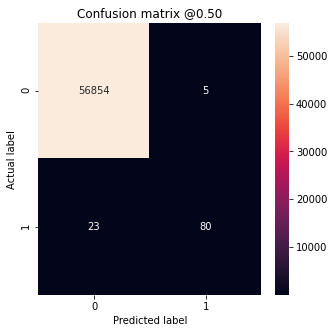

In [31]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [32]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 20])
    plt.ylim([80, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

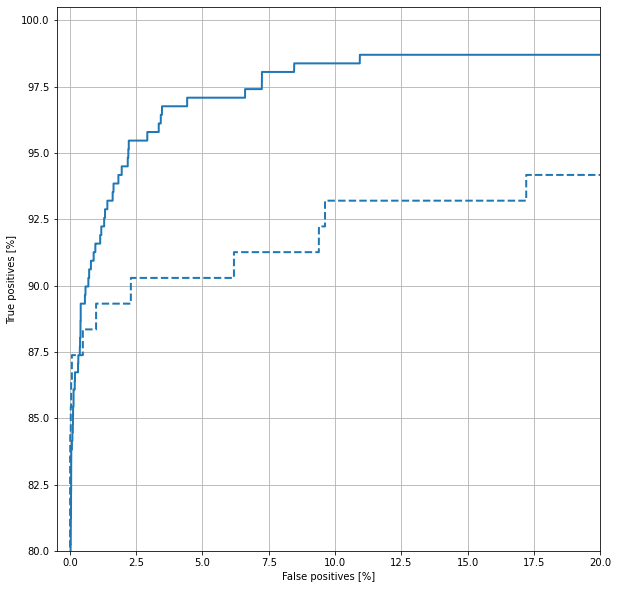

In [33]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

In [34]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

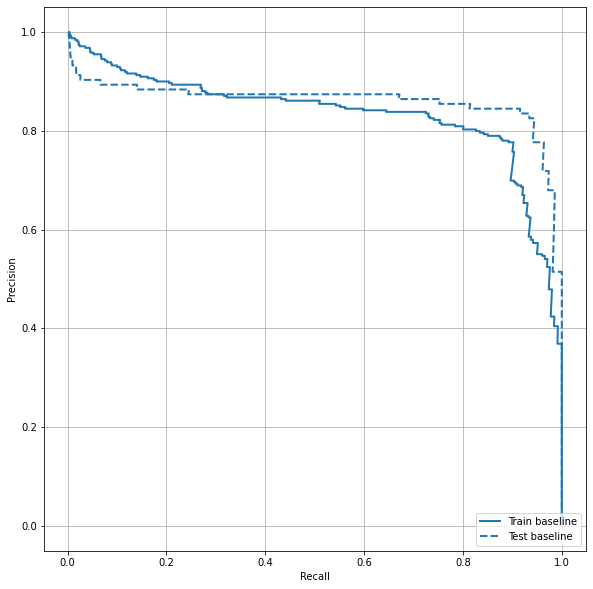

In [35]:
plot_prc('Train baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_prc('Test baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [36]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [37]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features, train_labels, epochs=EPOCHS, validation_data=(val_features, val_labels), batch_size=BATCH_SIZE, callbacks=[early_stopping], class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
90/90 [==============================] - 4s 23ms/step - loss: 1.2767 - tp: 217.0000 - fp: 363.0000 - tn: 238463.0000 - fn: 195.0000 - accuracy: 0.9977 - precision: 0.3741 - recall: 0.5267 - auc: 0.8697 - prc: 0.3769 - val_loss: 0.0087 - val_tp: 63.0000 - val_fp: 15.0000 - val_tn: 45474.0000 - val_fn: 17.0000 - val_accuracy: 0.9993 - val_precision: 0.8077 - val_recall: 0.7875 - val_auc: 0.9688 - val_prc: 0.7268
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 0.6198 - tp: 216.0000 - fp: 867.0000 - tn: 181100.0000 - fn: 93.0000 - accuracy: 0.9947 - precision: 0.1994 - recall: 0.6990 - auc: 0.9243 - prc: 0.4422 - val_loss: 0.0132 - val_tp: 67.0000 - val_fp: 43.0000 - val_tn: 45446.0000 - val_fn: 13.0000 - val_accuracy: 0.9988 - val_precision: 0.6091 - val_recall: 0.8375 - val_auc: 0.9741 - val_prc: 0.7644
Epoch 3/100

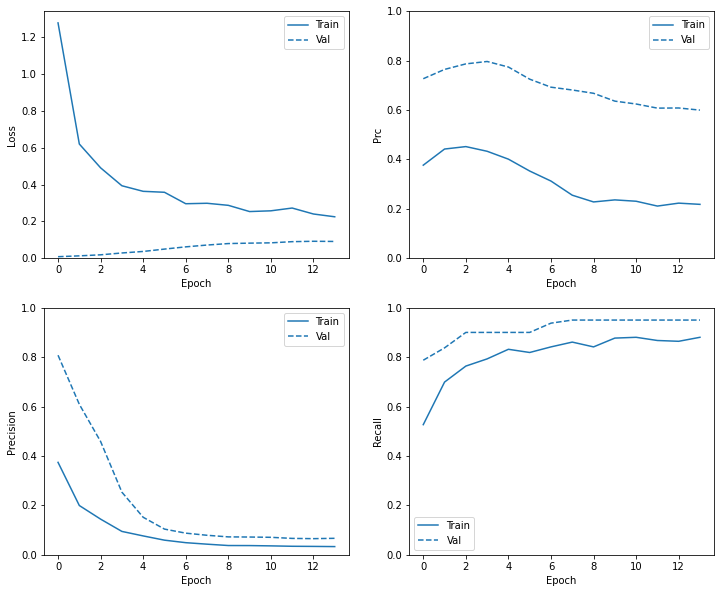

In [38]:
plot_metrics(weighted_history)

In [39]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.030048485845327377
tp :  91.0
fp :  333.0
tn :  56526.0
fn :  12.0
accuracy :  0.9939433336257935
precision :  0.2146226465702057
recall :  0.8834951519966125
auc :  0.9621898531913757
prc :  0.7793689370155334

Legitimate Transactions Detected (True Negative):  56526
Legitimate Transactions Incorrectly detected (False Positive):  333
Fraudulent Transactions Missed (False Negative):  12
Fraudulent Transactions Detected (True Positive):  91
Total Fraudulent Transactions:  103


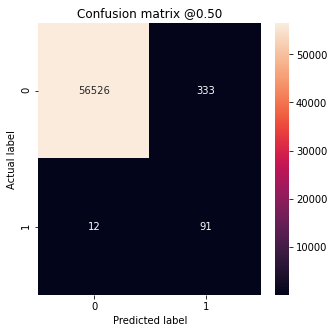

In [40]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

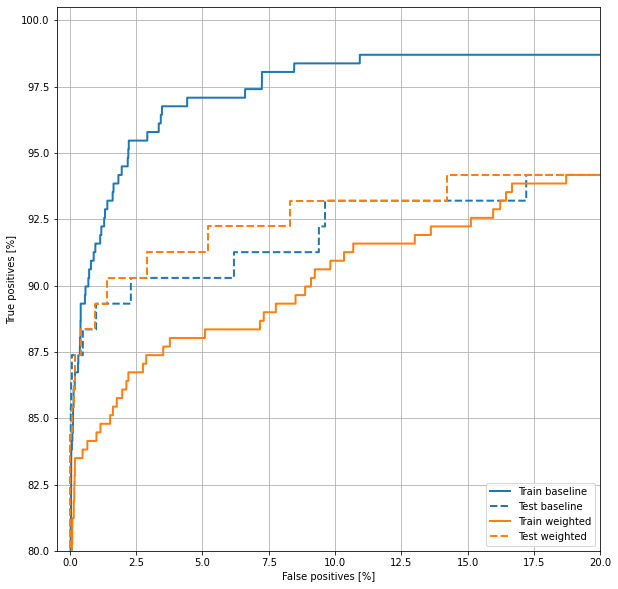

In [41]:
plot_roc('Train baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc('Train weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_roc('Test weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

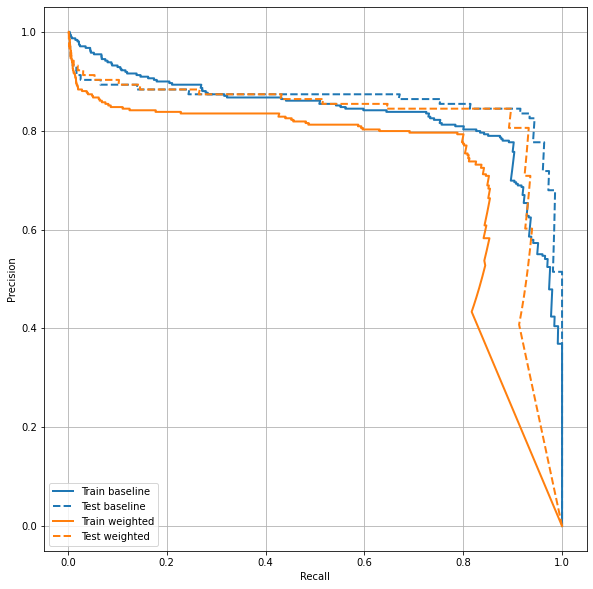

In [42]:
plot_prc('Train baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_prc('Test baseline', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc('Train weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_prc('Test weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower left')

In [44]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [45]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

In [46]:
print(res_pos_features.shape)
print(res_pos_labels.shape)

(181967, 29)
(181967,)


In [47]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_features))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

In [48]:
resampled_features.shape

(363934, 29)

In [49]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()

    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [50]:
for feature, label in pos_ds.take(1):
    print('Features:\n', feature.numpy())
    print('\nLabels:', label.numpy())

Features:
 [-5.          2.70565761 -5.          3.88337496 -4.31131314 -0.09856818
 -5.         -2.66951047 -4.34502863 -5.          5.         -5.
 -1.56520778 -5.          1.29610942 -5.         -5.         -4.65641394
  3.08674966  1.16865303 -3.34916333  2.3267611   1.57196619 -0.8969038
 -0.55475155 -0.22277522  0.80637114  0.46927897 -1.45363125]

Labels: 1


In [51]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [52]:
for features, labels in resampled_ds.take(1):
    print(labels.numpy().mean())

0.49560546875


In [53]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [54]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(resampled_ds, epochs=EPOCHS, steps_per_epoch=resampled_steps_per_epoch, callbacks=[early_stopping], validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 23s 73ms/step - loss: 0.3912 - tp: 251673.0000 - fp: 74586.0000 - tn: 266701.0000 - fn: 33346.0000 - accuracy: 0.8277 - precision: 0.7714 - recall: 0.8830 - auc: 0.9305 - prc: 0.9399 - val_loss: 0.2286 - val_tp: 76.0000 - val_fp: 1148.0000 - val_tn: 44341.0000 - val_fn: 4.0000 - val_accuracy: 0.9747 - val_precision: 0.0621 - val_recall: 0.9500 - val_auc: 0.9821 - val_prc: 0.7974
Epoch 2/100
278/278 [==============================] - 19s 69ms/step - loss: 0.1973 - tp: 258226.0000 - fp: 16070.0000 - tn: 268182.0000 - fn: 26866.0000 - accuracy: 0.9246 - precision: 0.9414 - recall: 0.9058 - auc: 0.9759 - prc: 0.9805 - val_loss: 0.1139 - val_tp: 76.0000 - val_fp: 898.0000 - val_tn: 44591.0000 - val_fn: 4.0000 - val_accuracy: 0.9802 - val_precision: 0.0780 - val_recall: 0.9500 - val_auc: 0.9832 - val_prc: 0.8096
Epoch 3/100
278/278 [==============================] - 19s 68ms/step - loss: 0.1539 - tp: 263386.0000 - fp: 12067.0000 - tn: 27

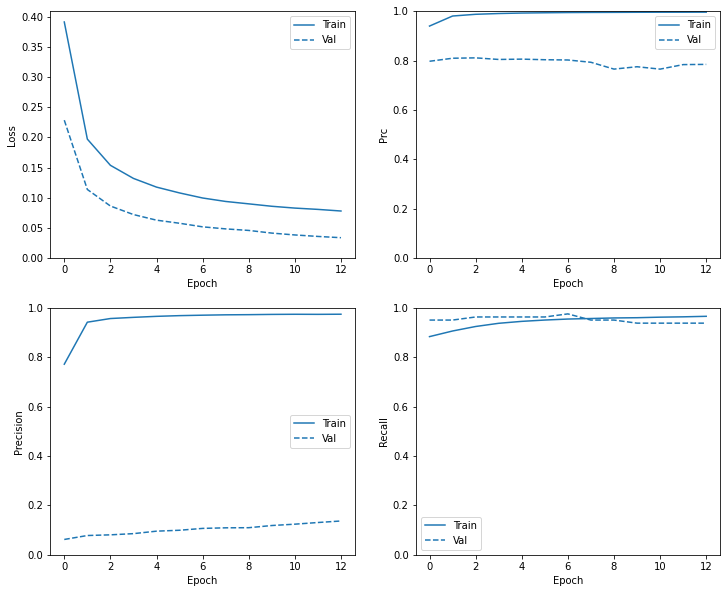

In [55]:
plot_metrics(resampled_history)

In [56]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(resampled_ds, steps_per_epoch=20, epochs=10*EPOCHS, callbacks=[early_stopping], validation_data=val_ds)

Epoch 1/1000
20/20 [==============================] - 5s 132ms/step - loss: 0.7453 - tp: 16790.0000 - fp: 12445.0000 - tn: 53367.0000 - fn: 3927.0000 - accuracy: 0.8108 - precision: 0.5743 - recall: 0.8104 - auc: 0.9161 - prc: 0.8312 - val_loss: 0.8591 - val_tp: 78.0000 - val_fp: 28037.0000 - val_tn: 17452.0000 - val_fn: 2.0000 - val_accuracy: 0.3847 - val_precision: 0.0028 - val_recall: 0.9750 - val_auc: 0.9589 - val_prc: 0.5948
Epoch 2/1000
20/20 [==============================] - 2s 81ms/step - loss: 0.5872 - tp: 18034.0000 - fp: 10831.0000 - tn: 9557.0000 - fn: 2538.0000 - accuracy: 0.6736 - precision: 0.6248 - recall: 0.8766 - auc: 0.8513 - prc: 0.8963 - val_loss: 0.7651 - val_tp: 78.0000 - val_fp: 22667.0000 - val_tn: 22822.0000 - val_fn: 2.0000 - val_accuracy: 0.5025 - val_precision: 0.0034 - val_recall: 0.9750 - val_auc: 0.9645 - val_prc: 0.7137
Epoch 3/1000
20/20 [==============================] - 2s 79ms/step - loss: 0.5110 - tp: 18262.0000 - fp: 9548.0000 - tn: 10990.0000 - 

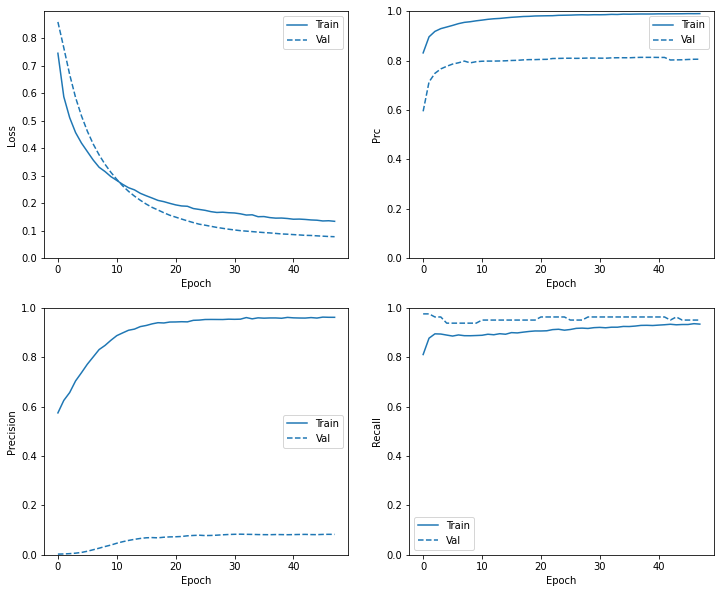

In [57]:
plot_metrics(resampled_history)

In [58]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.09004612267017365
tp :  91.0
fp :  1135.0
tn :  55724.0
fn :  12.0
accuracy :  0.9798637628555298
precision :  0.07422512024641037
recall :  0.8834951519966125
auc :  0.9604886770248413
prc :  0.7927858829498291

Legitimate Transactions Detected (True Negative):  55724
Legitimate Transactions Incorrectly detected (False Positive):  1135
Fraudulent Transactions Missed (False Negative):  12
Fraudulent Transactions Detected (True Positive):  91
Total Fraudulent Transactions:  103


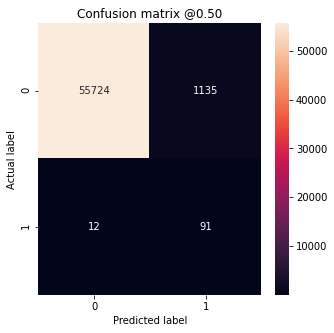

In [60]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)

print()
plot_cm(test_labels, test_predictions_resampled)

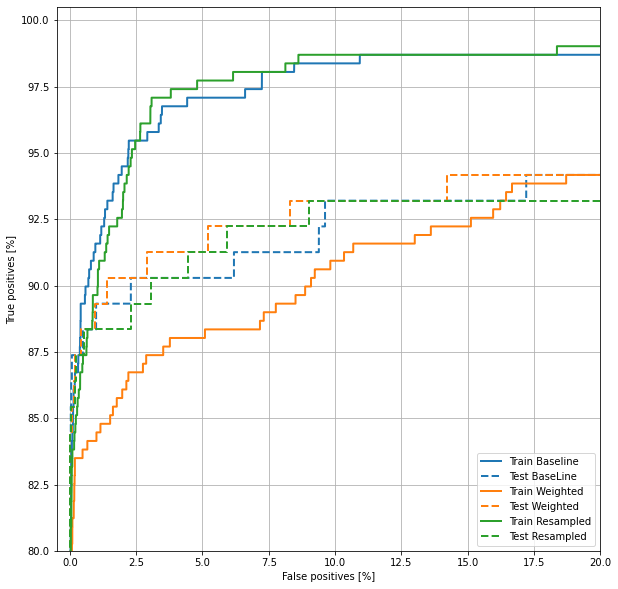

In [63]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test BaseLine', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_roc('Test Weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc('Train Resampled', train_labels, train_predictions_resampled, color=colors[2])
plot_roc('Test Resampled', test_labels, test_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

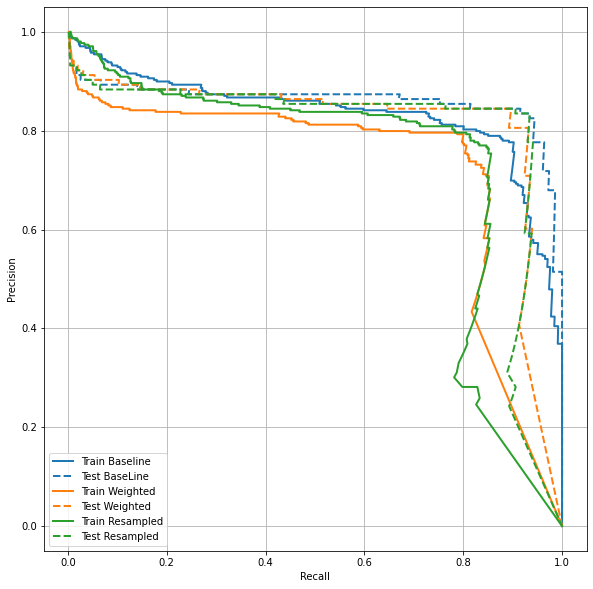

In [65]:
plot_prc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_prc('Test BaseLine', test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_prc('Test Weighted', test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc('Train Resampled', train_labels, train_predictions_resampled, color=colors[2])
plot_prc('Test Resampled', test_labels, test_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower left')